In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
tf.config.set_visible_devices(physical_devices[2], 'GPU')

from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
import keras.backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import albumentations as A
import random

from deep_globe_segmentation import models, dataset_utils as dataset, plot_utils as plt

2024-01-10 23:10:26.453001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 23:10:26.973588: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/buu3clj/radar_ws/tf211-env/lib/
2024-01-10 23:10:26.973632: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/buu3clj/radar_ws/tf211-env/lib/
2024-01-10 23:10:26.973636: W tensorflow/compiler/tf2t

Num GPUs: 4


In [2]:
input_folder = '/home/buu3clj/radar_ws/deep_globe_segmentation/dataset/cropped_dataset'
weights_path_resnet50 = '/home/buu3clj/radar_ws/deep_globe_segmentation/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path_inception_resnet_v2 = '/home/buu3clj/radar_ws/deep_globe_segmentation/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
output_folder = '/home/buu3clj/radar_ws/deep_globe_segmentation/models'

In [3]:
image_files = [filename for filename in os.listdir(input_folder) if filename.endswith('.jpg')]
mask_files = [filename for filename in os.listdir(input_folder) if filename.endswith('.png')]

image_files.sort()
mask_files.sort()

combined = list(zip(image_files, mask_files))
random.shuffle(combined)
image_files[:], mask_files[:] = zip(*combined)

image_files_train, image_files_val, mask_files_train, mask_files_val = train_test_split(
    image_files, mask_files, test_size=0.3, random_state=42, shuffle=True)

In [4]:
num_classes = 7
colors = [
    [0, 255, 255],   # urban_land
    [255, 255, 0],   # agriculture_land
    [255, 0, 255],   # rangeland
    [0, 255, 0],     # forest_land
    [0, 0, 255],     # water
    [255, 255, 255], # barren_land
    [0, 0, 0]        # unknown
]
class_names = [
    "Urban Land",
    "Agriculture Land",
    "Rangeland",
    "Forest Land",
    "Water",
    "Barren Land",
    "Unknown"
]

In [5]:
class_weights = dataset.calculate_class_weights(mask_files, colors, input_folder)
class_weights[6] = 1 # Unknown weight should be 1
print("Class Weights:", class_weights),

Class Weights: {0: 1.3908685526065514, 1: 0.24779873855539716, 2: 1.581703045618714, 3: 1.3963168001957018, 4: 4.013703206270928, 5: 1.5568543438690847, 6: 1}


(None,)

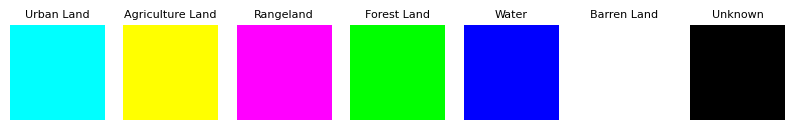

In [6]:
plt.display_color_classes(colors, class_names)

In [7]:
# plt.plot_images_and_masks(input_folder, image_files_train[:7], mask_files_train[:7], load=True)

In [8]:
spatial_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
])

color_augmentation = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=25, val_shift_limit=15, p=0.5),
])

In [9]:
data_gen = dataset.data_generator(input_folder, colors, image_files_train, mask_files_train, 16, num_classes, spatial_augmentation, color_augmentation)
images, masks = next(data_gen)

# plt.plot_images_with_overlaid_masks(images, masks, colors)

In [10]:
data_gen = dataset.data_generator(input_folder, colors, image_files_train, mask_files_train, 8, num_classes, spatial_augmentation, color_augmentation)
images, masks = next(data_gen)
masks = [dataset.one_hot_to_rgb(mask, colors) for mask in masks]
# plt.plot_images_and_masks(input_folder, images, masks)

In [11]:
# model = models.build_resnet50_unet((512,512,3), num_classes, weights_path_resnet50)
# model = models.build_inception_resnetv2_unet((512,512,3), num_classes, weights_path_inception_resnet_v2)
model = models.build_resnet50_unet_v2((512,512,3), num_classes, weights_path_resnet50)

model.compile(optimizer=Adam(learning_rate=0.00005), loss=models.weighted_dice_loss(class_weights), metrics=['accuracy'])

print(model.summary())

2024-01-10 23:11:36.745356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 23:11:36.750135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-10 23:11:36.751201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-10 23:11:36.752179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "ResNet50-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                      

In [12]:
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * 0.85

lr_scheduler = LearningRateScheduler(scheduler)

checkpoint = ModelCheckpoint(
    os.path.join(output_folder, 'best_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [13]:
batch_size = 8

data_gen_train = dataset.data_generator(input_folder, colors, image_files_train, mask_files_train, batch_size, num_classes, spatial_augmentation, color_augmentation)
data_gen_val = dataset.data_generator(input_folder, colors, image_files_val, mask_files_val, batch_size, num_classes, spatial_augmentation, color_augmentation)

history = model.fit(
    data_gen_train,
    validation_data=data_gen_val,
    epochs=30,
    steps_per_epoch=len(image_files_train) // batch_size,
    validation_steps=len(image_files_val) // batch_size,
    callbacks=[lr_scheduler, checkpoint]
)

Epoch 1/30


2024-01-10 23:11:41.925922: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inResNet50-UNet/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-10 23:11:42.927832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-01-10 23:11:43.900149: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


137/137 [==============================] - ETA: 0s - loss: 1.2600 - accuracy: 0.3082
Epoch 1: val_loss improved from inf to 1.55592, saving model to /home/buu3clj/radar_ws/deep_globe_segmentation/models/best_model.h5
137/137 [==============================] - 130s 874ms/step - loss: 1.2600 - accuracy: 0.3082 - val_loss: 1.5559 - val_accuracy: 0.0403 - lr: 5.0000e-05
Epoch 2/30
137/137 [==============================] - ETA: 0s - loss: 1.0651 - accuracy: 0.5513
Epoch 2: val_loss did not improve from 1.55592
137/137 [==============================] - 122s 868ms/step - loss: 1.0651 - accuracy: 0.5513 - val_loss: 1.5563 - val_accuracy: 0.0404 - lr: 5.0000e-05
Epoch 3/30
137/137 [==============================] - ETA: 0s - loss: 0.9824 - accuracy: 0.6241
Epoch 3: val_loss did not improve from 1.55592
137/137 [==============================] - 119s 868ms/step - loss: 0.9824 - accuracy: 0.6241 - val_loss: 1.5561 - val_accuracy: 0.0404 - lr: 5.0000e-05
Epoch 4/30
137/137 [=====================

KeyboardInterrupt: 

In [ ]:
with tf.keras.utils.custom_object_scope({'dice_loss': models.dice_loss, 'weighted_dice_loss': models.weighted_dice_loss(class_weights)}):
    model = tf.keras.models.load_model(os.path.join(output_folder, 'best_model.h5'))

In [ ]:
batch_size = 8
test_gen = dataset.data_generator(input_folder, colors, image_files_val, mask_files_val, batch_size, num_classes, spatial_augmentation, color_augmentation)

all_true_labels = []
all_pred_labels = []

num_batches = len(image_files_val) // batch_size

for i, (images, true_masks) in enumerate(test_gen):
    if i >= num_batches:
        break

    pred_masks = model.predict(images, verbose=0)

    true_labels = np.argmax(true_masks, axis=-1).flatten()
    pred_labels = np.argmax(pred_masks, axis=-1).flatten()

    all_true_labels.append(true_labels)
    all_pred_labels.append(pred_labels)

y_true = np.concatenate(all_true_labels)
y_pred = np.concatenate(all_pred_labels)

print("Overall Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
print("Overall Confusion Matrix:")
print(cm)
plt.plot_confusion_matrix(cm, classes=class_names)

In [ ]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.plot_confusion_matrix(cm_normalized, classes=class_names, title='Normalized Confusion Matrix')

print("Class-wise Metrics:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

dice_scores = []
for i in range(num_classes):
    y_true_categorical = to_categorical(y_true, num_classes)
    y_pred_categorical = to_categorical(y_pred, num_classes)
    
    dice_score = dice_coefficient(y_true_categorical[:, i], y_pred_categorical[:, i])
    dice_scores.append(dice_score)
    print(f"Dice Coefficient for Class {class_names[i]}: {dice_score}")

In [ ]:
batch_size = 16
data_gen = dataset.data_generator(input_folder, colors, image_files_val, mask_files_val, batch_size, num_classes, spatial_augmentation, color_augmentation)

images, masks = next(data_gen)

predicted_masks = model.predict(images)

masks = [dataset.one_hot_to_rgb(mask, colors) for mask in masks]
predicted_masks = [dataset.one_hot_to_rgb(predicted_mask, colors) for predicted_mask in predicted_masks]

plt.plot_images_and_masks(input_folder, images, masks, predicted_masks=predicted_masks, load=False)